# Import bibliotek

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import TensorBoard
import matplotlib.pyplot as plt

# Import/normalizacja danych

In [2]:
(x_train,y_train), (x_test, _) = keras.datasets.mnist.load_data()
X = np.concatenate([x_train, x_test], axis=0)
X = np.expand_dims(X, -1).astype("float32") / 255

#Predefiniowanie liczby przestrzeni zmiennych ukrytych
latent_dim    = 2

# Sampling f 

In [3]:
class Sampling(layers.Layer):
    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

# Encoder

In [4]:
inputs = keras.Input(shape=(28, 28, 1))
x = layers.Conv2D(32, 3, strides=1, padding="same", activation="relu")(inputs)
x = layers.Conv2D(64, 3, strides=2, padding="same", activation="relu")(x)
x = layers.Conv2D(64, 3, strides=2, padding="same", activation="relu")(x)
x = layers.Conv2D(64, 3, strides=1, padding="same", activation="relu")(x)
x = layers.Flatten()(x)
x = layers.Dense(16, activation="relu")(x)
###########################################################################
z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
z = Sampling()([z_mean, z_log_var])
###########################################################################
encoder = keras.Model(inputs, [z_mean, z_log_var, z], name="encoder")
#encoder.summary()

# Decoder

In [5]:
inputs = keras.Input(shape=(latent_dim,))
x = layers.Dense(7 * 7 * 64, activation="relu")(inputs)
x = layers.Reshape((7, 7, 64))(x)
x = layers.Conv2DTranspose(64, 3, strides=1, padding="same", activation="relu")(x)
x = layers.Conv2DTranspose(64, 3, strides=2, padding="same", activation="relu")(x)
x = layers.Conv2DTranspose(32, 3, strides=2, padding="same", activation="relu")(x)
outputs = layers.Conv2DTranspose(1,  3, padding="same", activation="sigmoid")(x)
############################################################################
decoder = keras.Model(inputs, outputs, name="decoder")
#decoder.summary()

# Funkcja odpowiedzialna za wizualizacje

In [6]:
def wizualizacja(vae, n=30, figsize=15):
    digit_size = 28
    scale = 1.0
    figure = np.zeros((digit_size * n, digit_size * n))
    grid_x = np.linspace(-scale, scale, n)
    grid_y = np.linspace(-scale, scale, n)[::-1]

    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            z_sample = np.array([[xi, yi]])
            x_decoded = vae.decoder.predict(z_sample)
            digit = x_decoded[0].reshape(digit_size, digit_size)
            figure[
                i * digit_size : (i + 1) * digit_size,
                j * digit_size : (j + 1) * digit_size,
            ] = digit

    plt.figure(figsize=(figsize, figsize))
    start_range = digit_size // 2
    end_range = n * digit_size + start_range
    pixel_range = np.arange(start_range, end_range, digit_size)
    sample_range_x = np.round(grid_x, 1)
    sample_range_y = np.round(grid_y, 1)
    plt.xticks(pixel_range, sample_range_x)
    plt.yticks(pixel_range, sample_range_y)
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.imshow(figure, cmap="Greys_r")
    plt.show()

In [7]:
class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder

        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(
            name="reconstruction_loss"
        )
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]
    def train_step(self, data):
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)
            reconstruction_loss = tf.reduce_mean(tf.reduce_sum(keras.losses.binary_crossentropy(data, reconstruction), axis=(1, 2)))
            
            kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
            total_loss = reconstruction_loss + kl_loss

        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }

# Model uczony z użyciem dywergencji KL w funkcji kosztu

In [8]:
modelKL = VAE(encoder, decoder)
modelKL.compile(optimizer=keras.optimizers.Adam(), loss=tf.keras.losses.KLDivergence())
modelKL.fit(X, epochs=20, batch_size=128)

Epoch 1/20
547/547 [==============================] - 217s 394ms/step - reconstruction_loss: 194.6637 - kl_loss: 3.5729
Epoch 2/20
547/547 [==============================] - 217s 397ms/step - reconstruction_loss: 155.9467 - kl_loss: 5.2494
Epoch 3/20
547/547 [==============================] - 218s 398ms/step - reconstruction_loss: 151.1414 - kl_loss: 5.5925
Epoch 4/20
547/547 [==============================] - 217s 398ms/step - reconstruction_loss: 148.1589 - kl_loss: 5.8070
Epoch 5/20
547/547 [==============================] - 217s 398ms/step - reconstruction_loss: 146.1239 - kl_loss: 5.9499
Epoch 6/20
547/547 [==============================] - 216s 395ms/step - reconstruction_loss: 144.5049 - kl_loss: 6.0605
Epoch 7/20
547/547 [==============================] - 218s 398ms/step - reconstruction_loss: 143.4636 - kl_loss: 6.1355
Epoch 8/20
547/547 [==============================] - 217s 397ms/step - reconstruction_loss: 142.3955 - kl_loss: 6.2230
Epoch 9/20
547/547 [====================

# Wizualizacja dla modelu KL

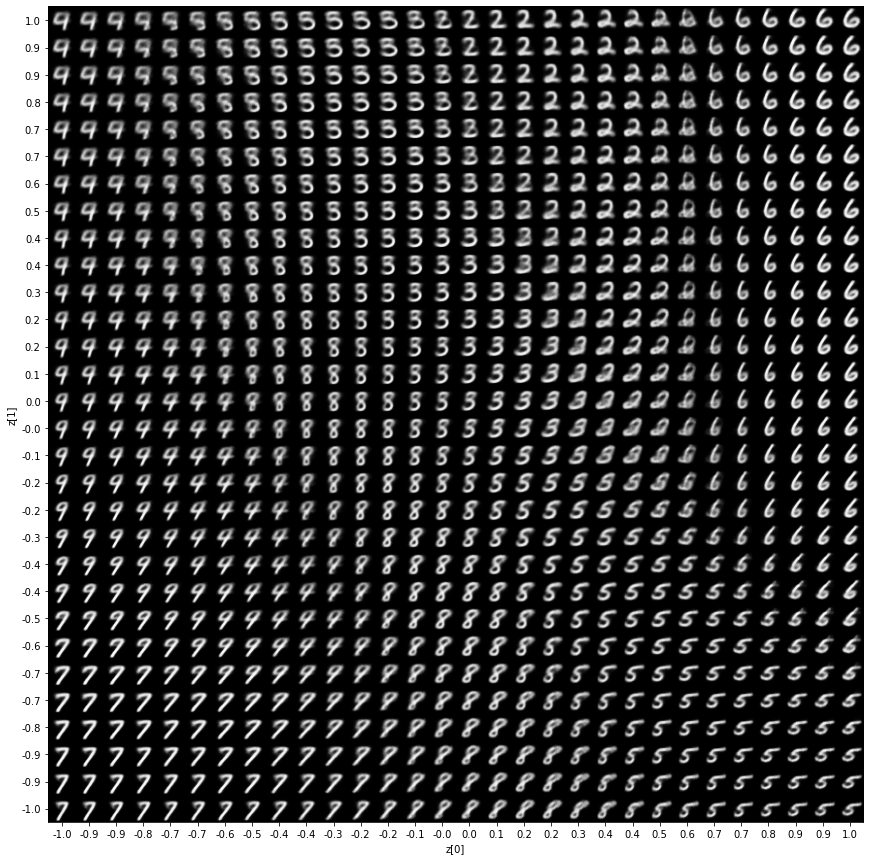

In [9]:
wizualizacja(modelKL)

# Model uczony bez użycia dywergencji KL w funkcji kosztu

In [10]:
model = VAE(encoder, decoder)
model.compile(optimizer=keras.optimizers.Adam(), loss=None)
model.fit(X, epochs=20, batch_size=128)

Epoch 1/20
547/547 [==============================] - 216s 394ms/step - reconstruction_loss: 136.1894 - kl_loss: 6.6237
Epoch 2/20
547/547 [==============================] - 216s 395ms/step - reconstruction_loss: 135.8327 - kl_loss: 6.6637
Epoch 3/20
547/547 [==============================] - 217s 397ms/step - reconstruction_loss: 135.6914 - kl_loss: 6.6645
Epoch 4/20
547/547 [==============================] - 218s 398ms/step - reconstruction_loss: 135.3211 - kl_loss: 6.6921
Epoch 5/20
547/547 [==============================] - 217s 397ms/step - reconstruction_loss: 135.1344 - kl_loss: 6.6875
Epoch 6/20
547/547 [==============================] - 218s 398ms/step - reconstruction_loss: 134.8927 - kl_loss: 6.7130
Epoch 7/20
547/547 [==============================] - 218s 399ms/step - reconstruction_loss: 134.7781 - kl_loss: 6.7191
Epoch 8/20
547/547 [==============================] - 218s 399ms/step - reconstruction_loss: 134.5393 - kl_loss: 6.7487
Epoch 9/20
547/547 [====================

# Wizualizacja dla modelu bez KL

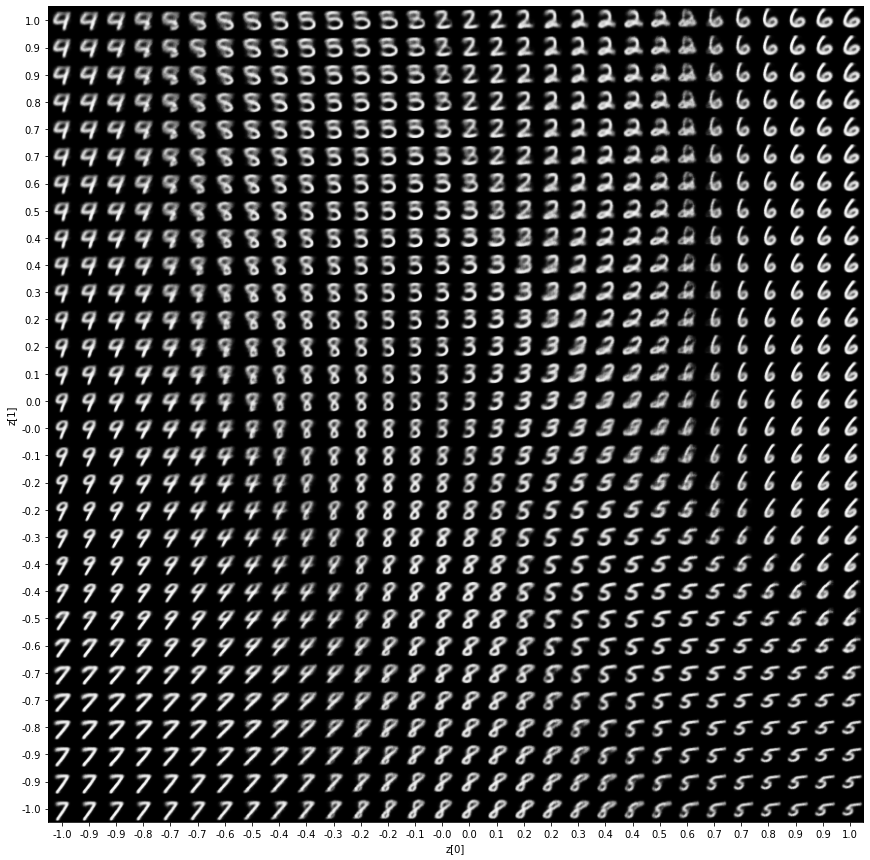

In [11]:
wizualizacja(model)

# Wnioski
Po wyliczeniu 2 modeli możemy zaobserwować to, że w przypadku modelu uczonego z użyciem dywergencji KL,   
loss na początku jest wyższy niż w przypadku modelu w którym go nie zastosowaliśmy. Jednak w trakcie uczenia nie wykazuje on  znacznej poprawy w przeciwieństwie do modelu KL, który z epoki na epokę osiąga coraz lepsze wyniki.